## Regularization motivation

In [18]:
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.linear_model import LinearRegression
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import numpy.linalg as npla
%matplotlib inline

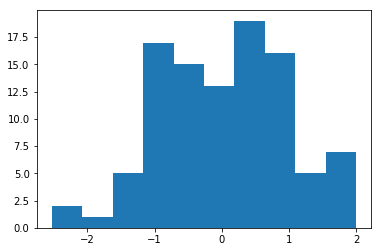

In [19]:
N=100
y = npr.randn(N,1)
plt.hist(y);

- Imagine your training set only contains the $y$-values, and they are shown above.
- How can you predict a new $y$?
- Reasonable idea: predict the mean value.

In [20]:
class MeanPredictor():
    def fit(self,y):
        self.mean = np.mean(y)
    def predict(self):
        return self.mean
mp = MeanPredictor()
mp.fit(y)
mp.predict()

0.0061958652392009195

Now imagine we have one feature $x$. 

In [21]:
x = y/2+npr.randn(N,1)/3

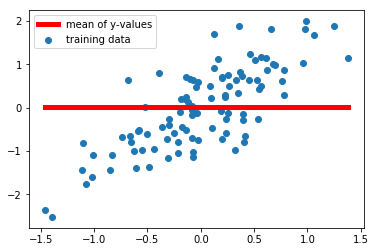

In [22]:
plt.scatter(x,y,label="training data")
mean = np.mean(y)
plt.plot((min(x),max(x)),(mean,mean), linewidth=5, c="red",label="mean of y-values");
plt.legend();

- Ok, but, why not use this feature? Let's do linear regression.

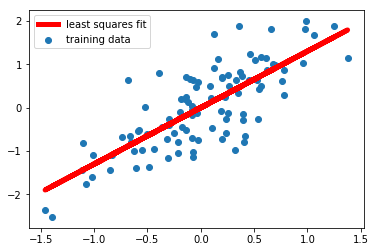

In [23]:
plt.scatter(x,y,label="training data")
w = np.sum(x*y)/np.sum(x*x)
plt.plot(x,w*x, linewidth=5, c="red",label="least squares fit");
plt.legend();

- But what if we don't trust this feature that much?
- Let's take a compromise between our prior model (mean value) and our new model.
- _We can achieve this by penalizing large values of $w$_.
- The loss becomes

$$\sum_{i=1}^n (wx_i-y_i)^2 + \lambda w^2$$

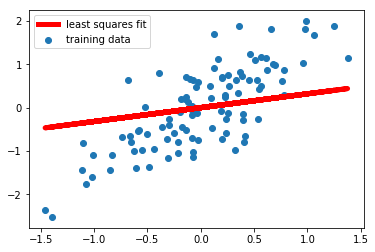

In [24]:
plt.scatter(x,y,label="training data")
w = np.sum(x*y)/(np.sum(x*x)+100)
plt.plot(x,w*x, linewidth=5, c="red",label="least squares fit");
plt.legend();

## Regularization demo

### Generate some synthetic data in 1-d

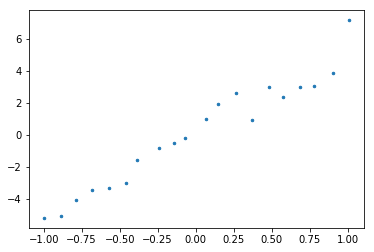

In [25]:
N = 20
X = np.linspace(-1,1,N)+npr.randn(N)*0.01
X=X[:,None]
y = npr.randn(N,1) + X*5

plt.plot(X,y,'.',markersize=5);

### Fit (interpolate) with degree $N-1$ polynomial

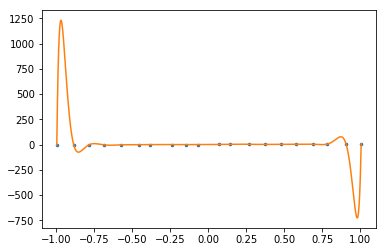

In [26]:
pf = PolynomialFeatures(N-1)
Z = pf.fit_transform(X)
w = npla.solve(Z.T @ Z, Z.T @ y)
grid = np.linspace(min(X),max(X),1000)[:,None]
grid_poly = pf.fit_transform(grid)

plt.plot(X,y,'.',markersize=5)
plt.plot(grid, grid_poly@w);

In [27]:
print(w)
print(max(abs(w)))

[[  4.03423621e-01]
 [  3.75871044e-02]
 [ -8.14604506e+00]
 [  9.42764674e+02]
 [  1.48160540e+03]
 [ -2.70206107e+04]
 [ -3.10032319e+04]
 [  3.16624012e+05]
 [  2.61489742e+05]
 [ -1.93611038e+06]
 [ -1.13432468e+06]
 [  6.80253647e+06]
 [  2.74384793e+06]
 [ -1.41685072e+07]
 [ -3.72445365e+06]
 [  1.71935623e+07]
 [  2.64318592e+06]
 [ -1.11757252e+07]
 [ -7.60599079e+05]
 [  2.99373163e+06]]
[ 17193562.25651893]


Problem: this results are crazy (overfitting). Interpretation: many large weights are cancelling each other out at the data points.

### Solution 1: lower degree polynomial

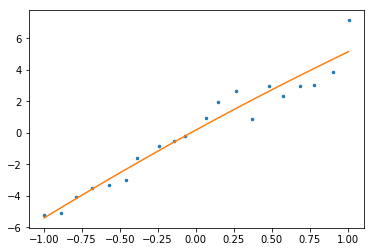

In [28]:
pf = PolynomialFeatures(2)
Z = pf.fit_transform(X)

w = npla.solve(Z.T @ Z, Z.T @ y)

plt.plot(X,y,'.',markersize=5)
grid_poly = pf.fit_transform(grid)
plt.plot(grid, grid_poly@w);

In [29]:
print(w)
print(max(abs(w)))

[[ 0.17368598]
 [ 5.27871899]
 [-0.31668694]]
[ 5.27871899]


Discussion:
- The lower degree polynomial looks good. 
- But if the true relationship really was complicated? Then if we restricted the degree of the polynomial, we'd miss out on it. 

### Solution 2: add L2-regularization

- Let's let the data decide how complex our model needs to be. 
- This is just like the complexity penalty from before, but now we can still optimize the loss easily.

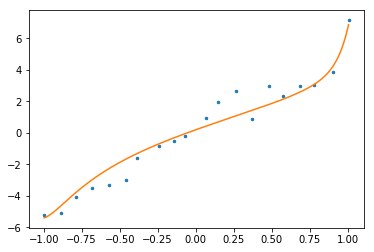

In [30]:
pf = PolynomialFeatures(19)
Z = pf.fit_transform(X)

λ = 1
w = npla.solve(Z.T @ Z + λ*np.eye(Z.shape[1]), Z.T @ y)

plt.plot(X,y,'.',markersize=5)
grid_poly = pf.fit_transform(grid)
plt.plot(grid, grid_poly@w);

In [31]:
print(w)
print(max(abs(w)))

[[ 0.19713002]
 [ 3.44867148]
 [-0.72681686]
 [ 1.04728126]
 [-0.30783022]
 [ 0.45715767]
 [-0.07212245]
 [ 0.25457682]
 [ 0.07216654]
 [ 0.17413897]
 [ 0.17157132]
 [ 0.13991767]
 [ 0.24478204]
 [ 0.12569624]
 [ 0.30071782]
 [ 0.12108065]
 [ 0.34442484]
 [ 0.12144468]
 [ 0.37911811]
 [ 0.12452621]]
[ 3.44867148]


Discussion:
- Regularization helped! Even though we used a degree $N-1$ polynomial, we didn't end up with a crazy model.
- We can add regularization to many models, not just least squares with a polynomial basis.

### Linear regression with RBF features



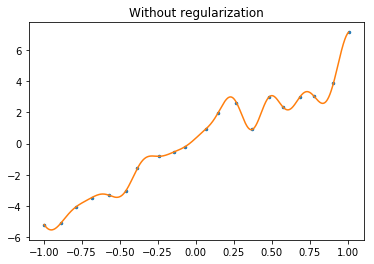

In [32]:
def euclidean_dist_squared(X, Xtest):
    return np.sum(X**2, axis=1)[:,None] + np.sum(Xtest**2, axis=1)[None] - 2 * np.dot(X,Xtest.T)
def RBF_features(Xtrain, Xtest, σ=1):
    return np.exp(-0.5*euclidean_dist_squared(Xtest,Xtrain)/σ**2)

Z = RBF_features(X,X,σ=0.1)

v = npla.solve(Z.T @ Z, Z.T @ y)

plt.plot(X,y,'.',markersize=5)
grid_RBF = RBF_features(X,grid,σ=0.1)
plt.plot(grid, grid_RBF@v);
plt.title("Without regularization");

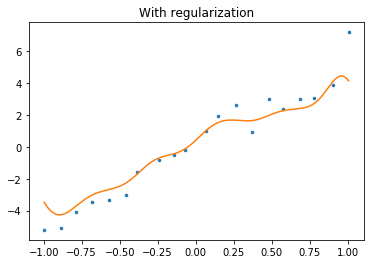

In [33]:
Z = RBF_features(X,X,σ=0.1)

λ=1
v = npla.solve(Z.T @ Z + λ*np.eye(Z.shape[1]), Z.T @ y)

plt.plot(X,y,'.',markersize=5)
grid_RBF = RBF_features(X,grid,σ=0.1)
plt.plot(grid, grid_RBF@v);
plt.title("With regularization");

### Discussion question

What's the difference between increasing $\lambda$ and increasing $\sigma$? Both seem to smooth out the curve.

Recall the 3 steps of modeling we discussed:

1. Choose model
2. Choose loss function
3. Choose optimization method

Well, $\sigma$ is a hyperparameter to step 1. In other words, it influences the range of _possible fits_. OTOH, $\lambda$ is a hyperparameter of step 2: it changes which of the possible fits we consider to be the best one.

(Caveat: the above reasoning is slightly muddy for nonparametric models, as the range of possible fits actually increases with $n$, so let's consider $n$ fixed for the above discussion.)

Another answer is that $\lambda$ also helps us deal with collinearity and conditioning issues.

#### More regularization thoughts (to read after class):

Imagine minimizing $f(w)=(w-1)^2+\lambda w^2$ with respect to $w$. The left-hand term wants to set $w=1$ to be minimized (equal to zero, in this case, since something squared can't be negative). The right-hand term wants to set $w=0$ to be minimized (again, equal to zero). What if we set $w=0$? Then we get a penalty of $1$ from the left-hand term and a penalty of zero from the right-hand term, for a total of $f(0)=1$. Now what if we set $w=1$? Then the left-hand term gives a penalty of zero and the right-hand term equals $\lambda$, so $f(1)=\lambda$. Then if $\lambda=1$ these two solutions are equally desirable, but if $\lambda=100$ then it becomes much better to set $w=0$ than $w=1$ and on the other hand if $\lambda=0.01$ then the opposite is true. So as you can see $\lambda$ controls the relative strength or "importance" of the two terms in our objective function.
 
In this particular case, because I picked such a simple example, we could also do the math by hand:
 
$$f(w)=(w-1)^2+\lambda w^2=(\lambda+1)w^2-2w+1$$
 
Setting the derivative to zero:
 
$$2(\lambda+1)w-2=0$$
 
yields
 
$$w=\frac{1}{1+\lambda}$$
 
So now we see it very clearly: if $\lambda=1$ then the solution lies at $0.5$ which is sensible, since the two terms are weighted equally. But as $\lambda$ grows the solution moves towards $w=0$, and as $\lambda$ shrinks towards zero the solutions goes towards $w=1$. 
 
All this is fairly analogous to linear regression situation except that

- $w$ is $d$-dimensional instead of $1$-dimensional
- the minimizer of the left-hand side is the $w$ that minimizes training error
 
So $\lambda$ controls the relative importance of training error vs. regularization.